In [1]:
import pandas as pd
import os
import shutil
import numpy as np

from QC.utils import shell_do

In [2]:
basedir = '/data/CARD/PD/GP2/raw_genotypes'
out_genotypes = '/data/CARD/PD/GP2/genotypes'
cohort_path = f'{basedir}/coriell'
sample_info_path = f'{cohort_path}/sample_info'
ilmn_files_path = '/data/CARD/PD/GP2/ilmn_files/'
bpm = f'{ilmn_files_path}/NeuroBooster_20042459_A1.bpm'
egt = f'{ilmn_files_path}/NBSCluster_file_n1393_011921.egt'
key_file = f'{sample_info_path}/KEY_FILE_GP2_Coriell_P1_25_042621_B1.txt'
pheno_file = f'{sample_info_path}/CORIELL_20210201_clinical.csv'

ped_dir = f'{cohort_path}/ped'
plink_dir = f'{cohort_path}/plink'
swarm_scripts_dir = f'{cohort_path}/swarm_scripts'
idat_dir = f'{cohort_path}/idats'
raw_idat_file_path = f'{cohort_path}/idats/GP2_coriell_idats'

# create ped and plink directories for raw geno outputs if they don't exist
os.makedirs(ped_dir, exist_ok=True)
os.makedirs(plink_dir, exist_ok=True)
os.makedirs(f'{plink_dir}/indiv_samples', exist_ok=True)
os.makedirs(swarm_scripts_dir, exist_ok=True)
os.makedirs(idat_dir, exist_ok=True)





iaap = f'{ilmn_files_path}/iaap-cli/iaap-cli'

In [21]:
pheno = pd.read_csv(pheno_file)
key = pd.read_csv(key_file, sep='\t')


pheno['Original_clinicalID'] = pheno['Original_clinicalID'].astype(str)
key['Sample_ID'] = key['Sample_ID'].astype(str)
key['filename'] = key['SentrixBarcode_A'].astype(str) + '_' + key['SentrixPosition_A']
pheno_out = key.merge(pheno, how='inner', left_on='Sample_ID', right_on='Original_clinicalID')
pheno_out['IID'] = pheno_out.SentrixBarcode_A.astype(str) + '_' + pheno_out.SentrixPosition_A.astype(str)
pheno_out['FID'] = 0
pheno_out['FID_new'] = 0
pheno_out['pheno'] = 0
pheno_out.loc[pheno_out.Phenotype == 'PD', 'pheno'] = 2
pheno_out.loc[pheno_out.Phenotype == 'Control', 'pheno'] = 1
pheno_out.loc[pheno_out.Phenotype == np.nan, 'pheno'] = 0

pheno_out[['FID','IID', 'FID_new', 'Sample_ID']].to_csv(f'{sample_info_path}/update_ids.txt', sep='\t', header=False, index=False)
pheno_out[['FID_new', 'Sample_ID', 'pheno']].to_csv(f'{sample_info_path}/update_pheno.txt', sep='\t', header=False, index=False)

In [54]:
# create a folder in idats for each plate in new idat_dir
for code in key.SentrixBarcode_A.unique():
    os.makedirs(f'{idat_dir}/{code}', exist_ok=True)

# copy idat intensity files to respective directories under idat_dir
missing_idats = []

for i, filename in enumerate(key.filename):
    sentrix_code = key.SentrixBarcode_A.iloc[i]
    grn = f'{raw_idat_file_path}/{filename}_Grn.idat'
    red = f'{raw_idat_file_path}/{filename}_Red.idat'

    if os.path.isfile(grn):
        shutil.copyfile(src=grn, dst=f'{idat_dir}/{sentrix_code}/{filename}_Grn.idat')
    else:
        missing_idats.append(grn)

    if os.path.isfile(red):
        shutil.copyfile(src=red, dst=f'{idat_dir}/{sentrix_code}/{filename}_Red.idat')
    else:
        missing_idats.append(red)

len(missing_idats)

0

In [55]:
with open(f'{swarm_scripts_dir}/idat_to_ped.swarm', 'w') as f:
    
    for code in key.SentrixBarcode_A.unique():
        
        idat_to_ped_cmd = f'\
{iaap} gencall \
{bpm} \
{egt} \
{ped_dir}/ \
-f {idat_dir}/{code} \
-p \
-t 8'
        
        f.write(f'{idat_to_ped_cmd}\n')
f.close()


In [57]:
!swarm -f {swarm_scripts_dir}/idat_to_ped.swarm -g 32 -t 16 --time=10:00:00 --logdir {swarm_scripts_dir}/logs --gres=lscratch:20 --partition=norm

14628402


In [58]:
# copy map file to match name of each ped
map_file = f'{ped_dir}/NeuroBooster_20042459_A1.map'
for filename in key.filename:
    ped = f'{ped_dir}/{filename}.ped'
    out_map = f'{ped_dir}/{filename}.map'
    if os.path.isfile(ped):
        shutil.copyfile(src=map_file, dst=out_map)
    else:
        print(f'{ped} does not exist!')
        print(f'{out_map} creation cancelled')

In [59]:

with open(f'{swarm_scripts_dir}/make_bed.swarm', 'w') as f:
    for filename in key.filename:
        ped = f'{ped_dir}/{filename}'
        make_bed_cmd = f'\
plink \
--file {ped} \
--make-bed \
--out {plink_dir}/indiv_samples/{filename}'

        f.write(f'{make_bed_cmd}\n')
f.close()


In [60]:
!swarm -f {swarm_scripts_dir}/make_bed.swarm -g 64 -t 32 --time=10:00:00 --logdir swarm --gres=lscratch:20 --partition=norm

14634832


In [61]:
# write plink merge command
with open(f"{plink_dir}/merge_bed.list", 'w') as f:
    for filename in key.filename:
        bed = f'{plink_dir}/indiv_samples/{filename}'
        f.write(f'{bed}\n')
f.close()

with open(f"{swarm_scripts_dir}/merge.swarm", 'w') as f:

    plink_merge_cmd = f'\
plink \
--merge-list {plink_dir}/merge_bed.list \
--update-ids {sample_info_path}/update_ids.txt \
--make-bed \
--out {plink_dir}/indiv_samples/coriell_merge'
    f.write(f"{plink_merge_cmd}")
f.close()

In [63]:
!swarm -f {swarm_scripts_dir}/merge.swarm -g 64 -t 32 --time=10:00:00 --logdir swarm --gres=lscratch:20 --partition=norm

14638754


In [64]:
!plink --bfile {plink_dir}/indiv_samples/coriell_merge --pheno {sample_info_path}/update_pheno.txt --make-bed --out {plink_dir}/coriell

PLINK v1.90b4.4 64-bit (21 May 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell.log.
Options in effect:
  --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/indiv_samples/coriell_merge
  --make-bed
  --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell
  --pheno /data/CARD/PD/GP2/raw_genotypes/coriell/sample_info/update_pheno.txt

1547809 MB RAM detected; reserving 773904 MB for main workspace.
2004347 variants loaded from .bim file.
2304 people (1307 males, 941 females, 56 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell.nosex .
2304 phenotype values present after --pheno.
phenotypes to be ignored, use the --allow-no-sex flag.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2304 founders and 0 nonfounders present.
Calculating allele fre

In [3]:
# run QC pipeline step-by-step
import pandas as pd
import os
import shutil
import zipfile

from QC.qc import callrate_prune, het_prune, sex_prune, related_prune, variant_prune, avg_miss_rates
from Ancestry.ancestry import run_ancestry, split_cohort_ancestry
from QC.utils import shell_do

geno_path = f'{basedir}/coriell/plink/coriell'
steps = []

avg_miss = avg_miss_rates(geno_path, f'{geno_path}_missing')
avg_miss

callrate_out = f'{geno_path}_callrate'
callrate = callrate_prune(geno_path, callrate_out)
steps.append(callrate)

sex_out = f'{callrate_out}_sex'
sex = sex_prune(callrate_out, sex_out)
steps.append(sex)

Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell --missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_missing


Average Missing Call Rate (lmiss): 0.01138650122141718
Average Missing Genotyping Rate (imiss): 0.011392406684027762

RUNNING: callrate_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell --mind 0.02 --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate



RUNNING: sex_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate --check-sex 0.25 0.75 --maf 0.05 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate --chr 23 --from-bp 2699520 --to-bp 154931043 --maf 0.05 --geno 0.05 --hwe 1E-5 --check-sex 0.25 0.75 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex.fails --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex



REMOVING TEMPORARY FILES




RUNNING: predict_ancestry


RUNNING: calculate_pcs



Executing: plink --bfile /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.common_snps --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps
Executing: flashpca --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps -d 50 --outpc /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.pcs --outvec /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.vec --outval /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.val --outpve /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.pve --outload /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.loadings --outmeansd /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.meansd




Labeled Reference Ancestry Counts:
AFR    504
EAS    504
SAS    489
AJ     471
EUR    404
AMR    347
AAC    157
FIN     99
Name: label, dtype: int64




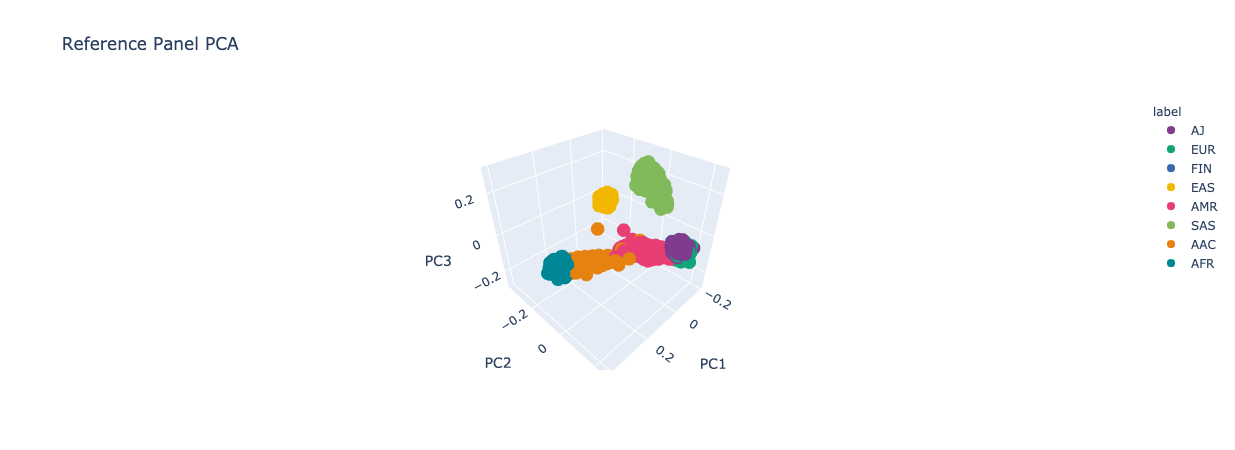

Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.common_snps --reference-allele /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.ref_allele --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps


/data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.meansd /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.loadings /data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps.projections


Executing: flashpca --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps --project --inmeansd /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.meansd --inload /data/CARD/PD/GP2/raw_genotypes/coriell/plink/ref_common_snps.loadings --outproj /data/CARD/PD/GP2/raw_genotypes/coriell/plink/pcs_common_snps.projections -v


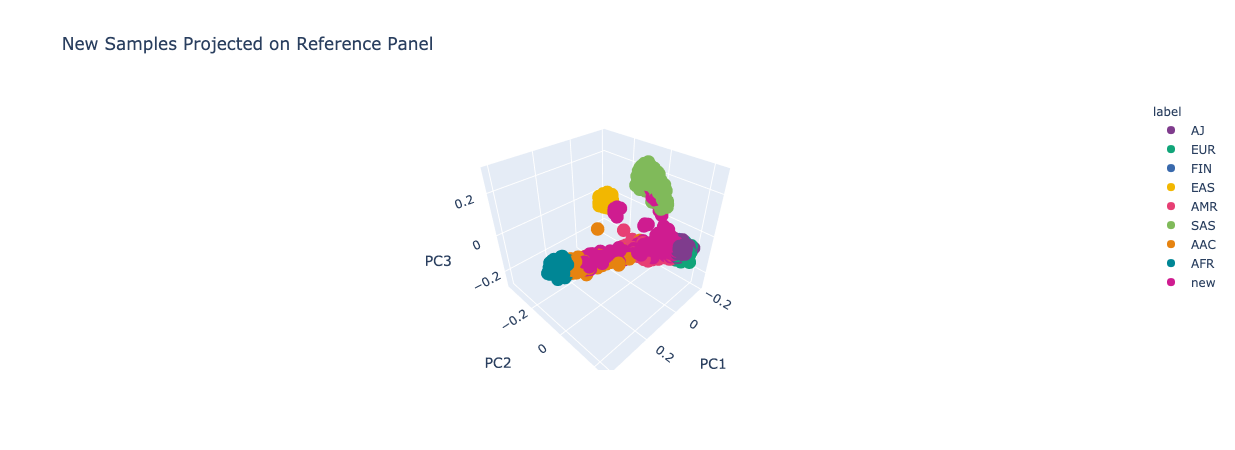


RUNNING: munge_pca_loadings


RUNNING: train_umap_classifier

Training Balanced Accuracy: 0.9655869259194596
Best Parameters: {'svc__C': 0.01, 'umap__a': 1.0, 'umap__b': 0.25, 'umap__n_components': 15, 'umap__n_neighbors': 20}
Balanced Accuracy on Test Set: 0.984873949579832


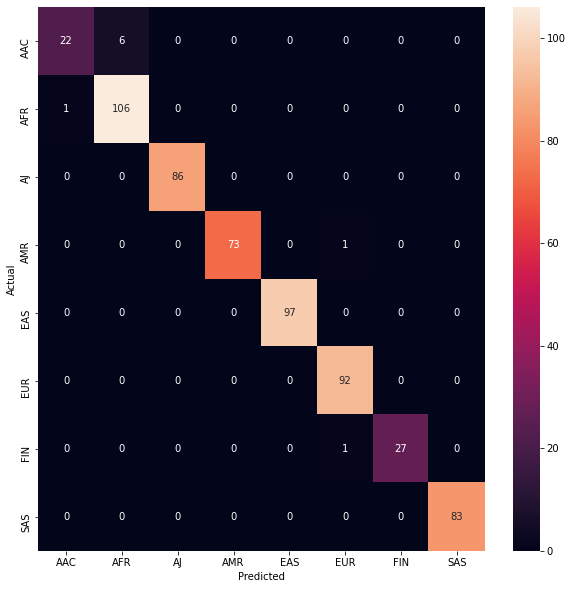


predicted:
 EUR    1740
AJ      262
AAC      94
AMR      91
SAS      14
EAS      14
FIN       1
Name: label, dtype: int64



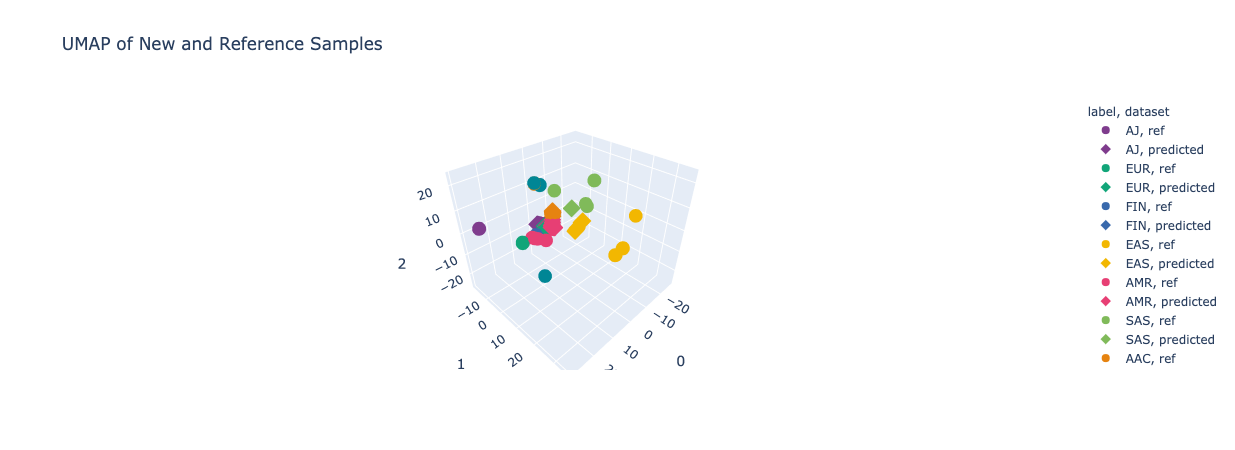

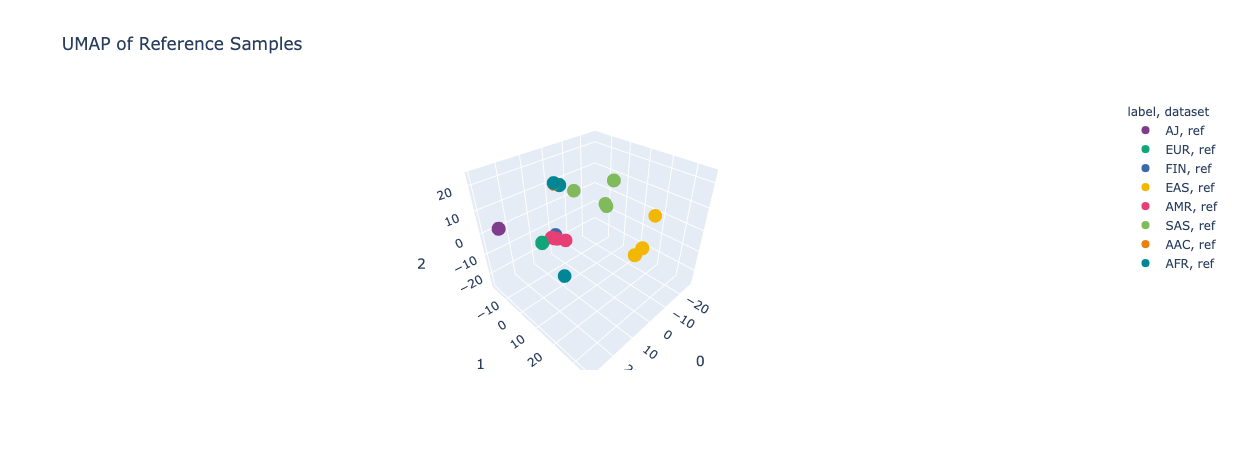

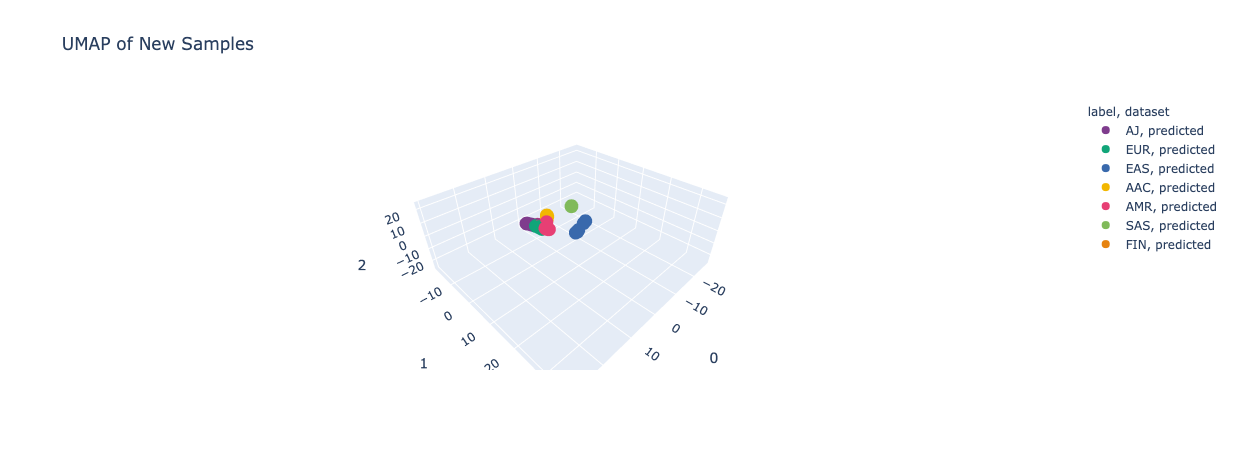

In [6]:
ancestry_out = f'{sex_out}_ancestry'
ref_dir_path = '/data/LNG/vitaled2/1kgenomes'
ref_panel = f'{ref_dir_path}/1kg_ashkj_ref_panel_gp2_pruned'
ref_labels = f'{ref_dir_path}/ref_panel_ancestry.txt'
# ancestry = run_ancestry(geno_path=sex_out, out_path=ancestry_out, ref_panel=ref_panel, ref_labels=ref_labels)

# rerunning with best params
best_params = {'svc__C': [0.01], 'umap__a': [1.0], 'umap__b': [0.25], 'umap__n_components': [15], 'umap__n_neighbors': [20]}
ancestry = run_ancestry(geno_path=sex_out, out_path=ancestry_out, ref_panel=ref_panel, ref_labels=ref_labels, train_param_grid=best_params)

In [7]:
pred_labels_path = ancestry['output']['predicted_labels']['labels_outpath']
cohort_split = split_cohort_ancestry(geno_path=sex_out, labels_path=pred_labels_path, out_path=ancestry_out)

Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ.samples --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR.samples --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS.samples --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/corie

In [16]:
het_dict = dict()
related_dict = dict()
variant_dict = dict()
avg_miss_dict = dict()
skipped_dict = dict()


for geno, label in zip(cohort_split['paths'], cohort_split['labels']):
    
    # check each genotype to see if there are controls. if no controls, these steps dont work!
    fam = pd.read_csv(f'{geno}.fam', header=None, sep='\s+', names=['FID','IID','PAT','MAT','SEX','PHENO'])
    if 1 in fam.PHENO.unique():
    
        # het
        het_out = f'{geno}_het'
        het = het_prune(geno, het_out)
        het_dict[label] = het

        # related
        related_out = f'{het_out}_related'
        related = related_prune(het_out, related_out)
        related_dict[label] = related
        
        # variant
        variant_out = f'{related_out}_variant'
        variant = variant_prune(related_out, variant_out)
        variant_dict[label] = variant
    
    else:
        outfiles_dict = {
             'plink_out': geno
         }
        
        metrics_dict = {}

        skipped = {
            'step': 'Skipped variant pruning. No Controls to filter!',
            'metrics': metrics_dict,
            'output': outfiles_dict
        }
    

        skipped_dict[label] = skipped
        print(f'Skipping Variant Pruning for {geno}. No Controls to filter!')

steps2 = [het_dict, related_dict, variant_dict, avg_miss_dict, skipped_dict]


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ --geno 0.01 --maf 0.05 --indep-pairwise 50 5 0.5 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het.outliers --make-bed --out /dat


REMOVING TEMPORARY FILES


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_total_grm_tmp --grm-cutof


REMOVING TEMPORARY FILES


RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_variant_mis_tmp2 --test-mishap --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AJ_het_related_variant_hap_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex


REMOVING TEMPORARY FILES


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR --geno 0.01 --maf 0.05 --indep-pairwise 50 5 0.5 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het.outliers --make-bed -


REMOVING TEMPORARY FILES


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_total_grm_tmp --g


REMOVING TEMPORARY FILES


RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_variant_mis_tmp2 --test-mishap --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EUR_het_related_variant_hap_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callr


REMOVING TEMPORARY FILES


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS --geno 0.01 --maf 0.05 --indep-pairwise 50 5 0.5 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het.outliers --make-bed -


REMOVING TEMPORARY FILES


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_total_grm_tmp --g


REMOVING TEMPORARY FILES


RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_variant_mis_tmp2 --test-mishap --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_EAS_het_related_variant_hap_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callr


REMOVING TEMPORARY FILES


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC --geno 0.01 --maf 0.05 --indep-pairwise 50 5 0.5 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het.outliers --make-bed -


REMOVING TEMPORARY FILES


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_total_grm_tmp --g


REMOVING TEMPORARY FILES


RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_variant_mis_tmp2 --test-mishap --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AAC_het_related_variant_hap_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callr


REMOVING TEMPORARY FILES


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR --geno 0.01 --maf 0.05 --indep-pairwise 50 5 0.5 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het.outliers --make-bed -


REMOVING TEMPORARY FILES


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_total_grm_tmp --g


REMOVING TEMPORARY FILES


RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_variant_mis_tmp2 --test-mishap --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_AMR_het_related_variant_hap_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callr


REMOVING TEMPORARY FILES


RUNNING: het_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS --geno 0.01 --maf 0.05 --indep-pairwise 50 5 0.5 --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS --extract /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_tmp.prune.in --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_tmp2 --het --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_tmp3
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS --remove /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het.outliers --make-bed -


REMOVING TEMPORARY FILES


RUNNING: related_prune



Executing: gcta --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het --autosome --maf 0.05 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_total_grm_tmp
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_total_grm_tmp --grm-cutoff 0.125 --make-grm --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_unrelated_grm_tmp
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het --keep /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_unrelated_grm_tmp.grm.id --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related
Executing: gcta --grm /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_total_grm_tmp --g


REMOVING TEMPORARY FILES


RUNNING: variant_prune



Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_variant_geno_tmp1 --test-missing --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_variant_mis_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_variant_geno_tmp1 --exclude /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_variant_mis_tmp1.exclude --make-bed --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_variant_mis_tmp2
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_variant_mis_tmp2 --test-mishap --out /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_SAS_het_related_variant_hap_tmp1
Executing: plink --bfile /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callr


REMOVING TEMPORARY FILES

Skipping Variant Pruning for /data/CARD/PD/GP2/raw_genotypes/coriell/plink/coriell_callrate_sex_ancestry_FIN. No Controls to filter!


In [17]:
with open(f'{geno_path}.QC_REPORT.txt', 'w') as f:
    f.write("QC REPORT\n")
    f.write("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    f.write("$$$$$$$$$$$$$$ Whole cohort steps $$$$$$$$$$$$$$$\n")
    f.write("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    f.write("\n")
    f.write(f"Missingness: {avg_miss}\n")
    f.write("\n")

    for step in steps:
        f.write("\n")
        f.write(f"STEP: {step['step']}\n")
        f.write(f"Metrics: {step['metrics']}\n")
        f.write("\n")
    
    f.write("\n")
    f.write("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    f.write("$$$$$$$$$$ Individual Ancestry steps $$$$$$$$$$$$\n")
    f.write("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    f.write("\n")
    
    for item in steps2:
        for key, step in item.items():
            f.write("\n")
            f.write(f"Ancestry Group: {key}\n")
            f.write(f"STEP: {step['step']}\n")
            f.write(f"{step['metrics']}\n")
            f.write("\n")

    for key, value in avg_miss_dict.items():
        f.write("\n")
        f.write(f"Ancestry Group: {key}\n")
        f.write("\n")
    
    f.write("\n")
    f.write("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    f.write("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    f.write("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    f.write("\n")
f.close()

In [18]:
!cat {geno_path}.QC_REPORT.txt

QC REPORT
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$ Whole cohort steps $$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

Missingness: {'avg_lmiss': 0.01138650122141718, 'avg_imiss': 0.011392406684027762}


STEP: callrate_prune
Metrics: {'outlier_count': 71}


STEP: sex_prune
Metrics: {'outlier_count': 17}


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$ Individual Ancestry steps $$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


Ancestry Group: AJ
STEP: het_prune
{'outlier_count': 0}


Ancestry Group: EUR
STEP: het_prune
{'outlier_count': 0}


Ancestry Group: EAS
STEP: het_prune
{'outlier_count': 0}


Ancestry Group: AAC
STEP: het_prune
{'outlier_count': 0}


Ancestry Group: AMR
STEP: het_prune
{'outlier_count': 0}


Ancestry Group: SAS
STEP: het_prune
{'outlier_count': 0}


Ancestry Group: AJ
STEP: related_prune
{'related_count': 3, 'duplicated_count': 2}


Ancestry Group: EUR
STEP: related_prune
{'related_count': 24,